In [1]:
! pip install arch

In [2]:
# Leer Archivos Drive
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# =====================
# Librerías estándar
# =====================
import sys
import warnings
from typing import Union, Optional
from datetime import datetime

# =====================
# Ciencia de datos
# =====================
import pandas as pd
import numpy as np

# =====================
# Visualización
# =====================
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# Series de tiempo y estadística
# =====================
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from scipy.stats import norm

# Phillips-Perron (con verificación de disponibilidad)
try:
    from arch.unitroot import PhillipsPerron
    HAVE_PP = True
except Exception:
    HAVE_PP = False

# =====================
# Configuración
# =====================
warnings.filterwarnings("ignore")

# =====================
# Importar funciones auxiliares desde Google Drive
# =====================
sys.path.append('/content/drive/MyDrive/Datos_EESS')
print(f"sys.path after adding: {sys.path}")  # Verificación
from funciones_auxiliares import *


sys.path after adding: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Datos_EESS']


In [4]:
# Leer csv
try:
    df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
    print("CSV file loaded successfully!")
    #display(df.head()) # Display the first 5 rows
except FileNotFoundError:
    print("Error: Make sure the file path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

CSV file loaded successfully!


In [ ]:
# Cargar
df_1 = to_datetime_index(df)

In [ ]:
# Calculate the first difference of the DataFrame
df_diff = df_1.diff().dropna()

# Display the first few rows of the new DataFrame
display(df_diff.head())

In [9]:
### BORRAR

df= to_datetime_index(df)

In [ ]:
df= df_diff.copy()


In [5]:
# Configuración según tests de raíz unitaria
series_cfg = {
    "volumen_DSP": {"d": 0, "s": 7},
    "volumen_NFP": {"d": 1, "s": 7},
    "volumen_NFC": {"d": 1, "s": 7},
}

# Horizonte de test (días al final de la serie)
H = 14

In [10]:
def grid_search_sarima(y_train, d, s,
                       p_max=2, q_max=2, P_max=1, Q_max=1,
                       D_grid=(0,1),
                       criterion="aic"):
    """
    Recorre SARIMA(p,d,q)(P,D,Q)[s] y ordena por AIC/BIC.
    Devuelve (tabla_ordenada, mejor_fila).
    """
    results = []
    for D in D_grid:
        for p in range(p_max+1):
            for q in range(q_max+1):
                for P in range(P_max+1):
                    for Q in range(Q_max+1):
                        try:
                            fit = SARIMAX(
                                y_train,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            ).fit(disp=False, maxiter=200)
                            results.append({
                                "order": (p,d,q),
                                "seasonal_order": (P,D,Q,s),
                                "aic": fit.aic,
                                "bic": fit.bic,
                                "converged": fit.mle_retvals.get("converged", True)
                            })
                        except Exception:
                            # guardo intento fallido para rastreo
                            results.append({
                                "order": (p,d,q),
                                "seasonal_order": (P,D,Q,s),
                                "aic": np.nan, "bic": np.nan, "converged": False
                            })
    res = pd.DataFrame(results)
    key = "aic" if criterion.lower() == "aic" else "bic"
    res_sorted = res.dropna(subset=[key]).sort_values(key).reset_index(drop=True)
    best = res_sorted.iloc[0] if not res_sorted.empty else None
    return res_sorted, best

In [11]:
def fit_best_sarima(y, d, s, h=14, series_name="", criterion="aic"):
    # Regularizar y split Train/Test
    y = regularize_daily(y)
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]

    # Grid search
    grid, best = grid_search_sarima(y_train, d=d, s=s, criterion=criterion)
    if best is None:
        raise RuntimeError(f"No se encontró modelo para {series_name}")

    best_order = tuple(best["order"])
    best_seas  = tuple(best["seasonal_order"])

    # Ajuste final con train
    fit = SARIMAX(
        y_train, order=best_order, seasonal_order=best_seas,
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False, maxiter=300)

    # Significatividad individual
    pvals = fit.pvalues.dropna().sort_values()
    signif_count = int((pvals < 0.05).sum())
    total_params = len(pvals)

    # Test global tipo LR vs modelo restringido (solo difs y sin AR/MA)
    try:
        restr = SARIMAX(
            y_train, order=(0,d,0), seasonal_order=(0,0,0,s),
            enforce_stationarity=False, enforce_invertibility=False
        ).fit(disp=False, maxiter=200)
        lr_stat, lr_p, df_ = fit.compare_lr_test(restr)
        lr_info = (float(lr_stat), float(lr_p), int(df_))
    except Exception:
        lr_info = (np.nan, np.nan, np.nan)

    # Diagnóstico residuos: Ljung-Box en lags s y 2s
    lb = acorr_ljungbox(fit.resid.dropna(), lags=[s, min(2*s, len(fit.resid)-1)], return_df=True)
    lb.index = [f"lag_{int(i)}" for i in lb.index]

    # Gráficos: ACF/PACF residuos
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    plot_acf(fit.resid.dropna(), lags=40, ax=axes[0]); axes[0].set_title(f"ACF residuos - {series_name}")
    plot_pacf(fit.resid.dropna(), lags=40, ax=axes[1], method="ywm"); axes[1].set_title(f"PACF residuos - {series_name}")
    plt.tight_layout(); plt.show()

    # Pronóstico sobre Test y métricas
    pred = fit.get_forecast(steps=len(y_test))
    f_mean = pred.predicted_mean
    f_int  = pred.conf_int()

    mae  = np.mean(np.abs(y_test - f_mean))
    rmse = np.sqrt(np.mean((y_test - f_mean)**2))
    m1   = mape(y_test, f_mean)
    m2   = smape(y_test, f_mean)

    # Plot Train/Test + Forecast
    plt.figure(figsize=(12,5))
    plt.plot(y_train.index, y_train, label="Train")
    plt.plot(y_test.index,  y_test,  label="Test")
    plt.plot(f_mean.index,  f_mean,  label="Pronóstico")
    try:
        plt.fill_between(f_int.index, f_int.iloc[:,0], f_int.iloc[:,1], alpha=0.2, label="IC 95%")
    except Exception:
        pass
    plt.title(f"{series_name} | SARIMA{best_order}x{best_seas} | {criterion.upper()}={best[criterion]}")
    plt.grid(True); plt.legend(); plt.show()

    #########

    # # Pronóstico sobre Test en niveles originales
    # pred = fit.get_forecast(steps=len(y_test))
    # f_mean = pred.predicted_mean
    # f_int  = pred.conf_int()

    # # Convertir a niveles originales si la serie tenía diferenciación
    # f_mean = f_mean.astype(float)
    # f_int = f_int.astype(float)

    # # --- Plot Observado (niveles) + Pronóstico ---
    # plt.figure(figsize=(12,5))
    # plt.plot(y.index, y.values, label="Observado")               # toda la serie en niveles
    # plt.plot(f_mean.index, f_mean.values, "--", label="Pronóstico")  # forecast en niveles
    # try:
    #     plt.fill_between(f_int.index, f_int.iloc[:,0], f_int.iloc[:,1], alpha=0.2, label="IC 95%")
    # except Exception:
    #     pass
    # plt.title(f"{series_name} | SARIMA{best_order}x{best_seas} | {criterion.upper()}={best[criterion]}")
    # plt.grid(True); plt.legend(); plt.show()
    # ######
    summary = {
        "Serie": series_name,
        "Mejor_order": best_order,
        "Mejor_seasonal": best_seas,
        "AIC": float(best["aic"]),
        "BIC": float(best["bic"]),
        "Params_signif(<0.05)/Total": f"{signif_count}/{total_params}",
        "LR_stat,p,df (vs ARIMA(0,d,0))": lr_info,     # significatividad global
        "LB_p(lag s)": float(lb["lb_pvalue"].iloc[0]),
        "LB_p(lag 2s)": float(lb["lb_pvalue"].iloc[1]),
        "MAE": float(mae), "RMSE": float(rmse),
        "MAPE(%)": float(m1), "sMAPE(%)": float(m2),
    }

    return {"grid": grid, "fit": fit, "summary": summary, "forecast": (f_mean, f_int, y_test)}



=== volumen_DSP (d=0, s=7) ===


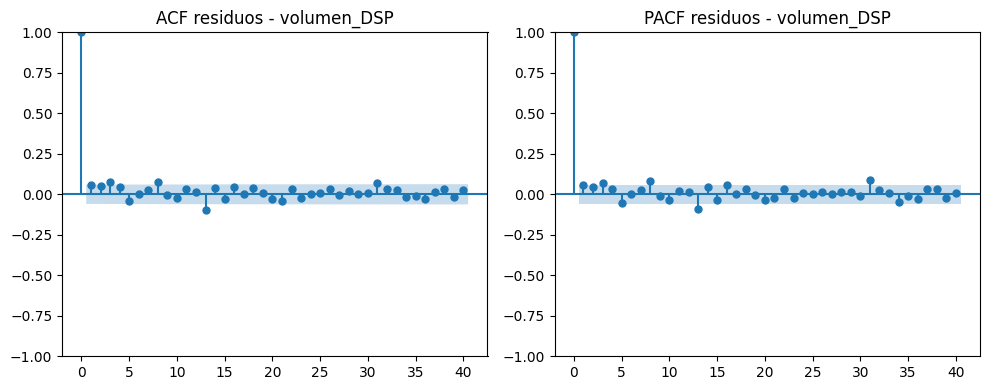

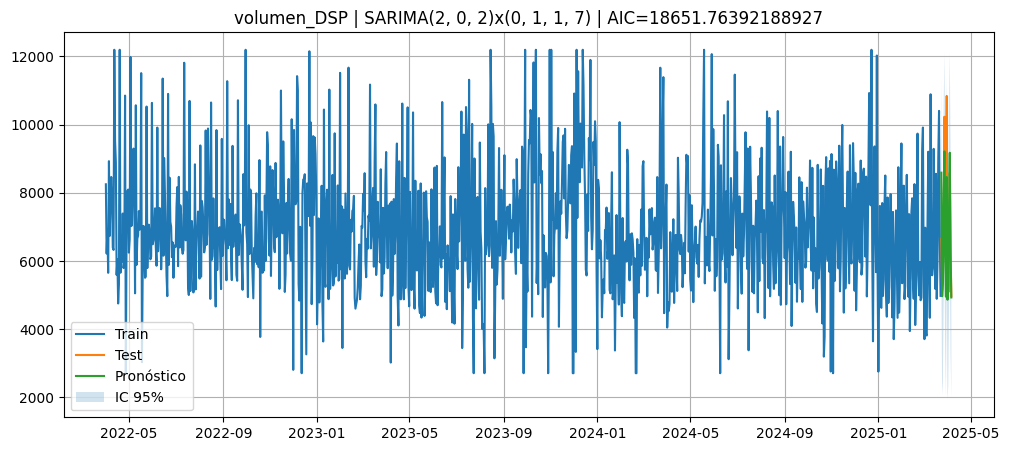

,order,seasonal_order,aic,bic
0,"(2, 0, 2)","(0, 1, 1, 7)",18651.763922,18681.622010
1,"(2, 0, 2)","(1, 1, 1, 7)",18653.763832,18688.598268
2,"(1, 0, 2)","(0, 1, 1, 7)",18654.300874,18679.182614
3,"(1, 0, 2)","(1, 1, 1, 7)",18656.273898,18686.131987
4,"(1, 0, 1)","(0, 1, 1, 7)",18669.932746,18689.841872



=== volumen_NFP (d=1, s=7) ===


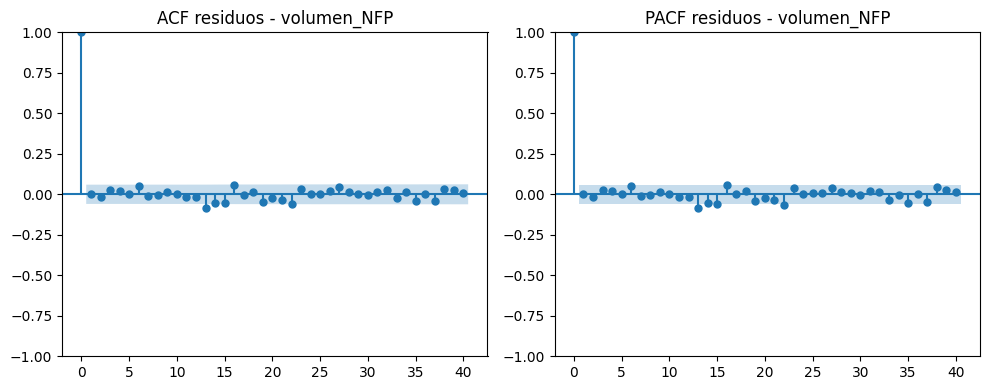

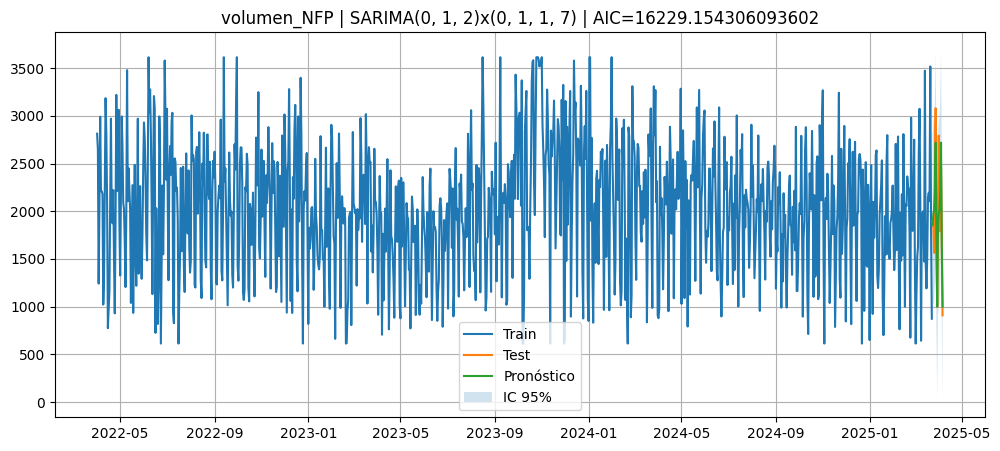

,order,seasonal_order,aic,bic
0,"(0, 1, 2)","(0, 1, 1, 7)",16229.154306,16249.055962
1,"(2, 1, 2)","(0, 1, 1, 7)",16229.902629,16259.755112
2,"(0, 1, 2)","(1, 1, 1, 7)",16231.152522,16256.029591
3,"(2, 1, 2)","(1, 1, 1, 7)",16231.841882,16266.669779
4,"(1, 1, 1)","(0, 1, 1, 7)",16243.658552,16263.563944



=== volumen_NFC (d=1, s=7) ===


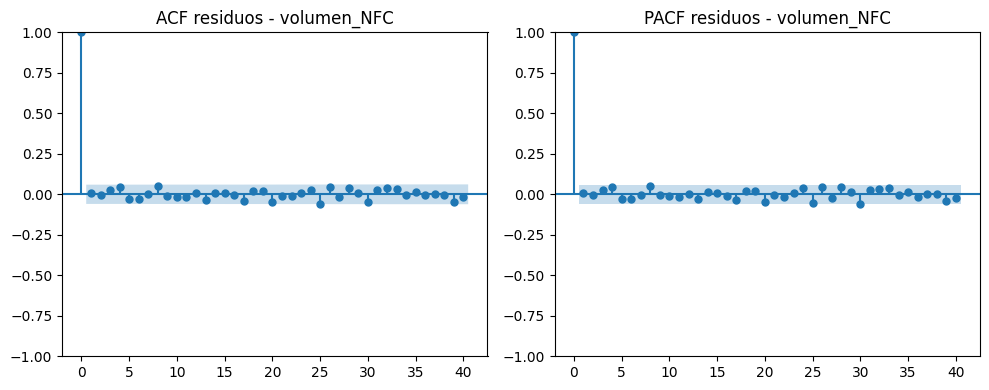

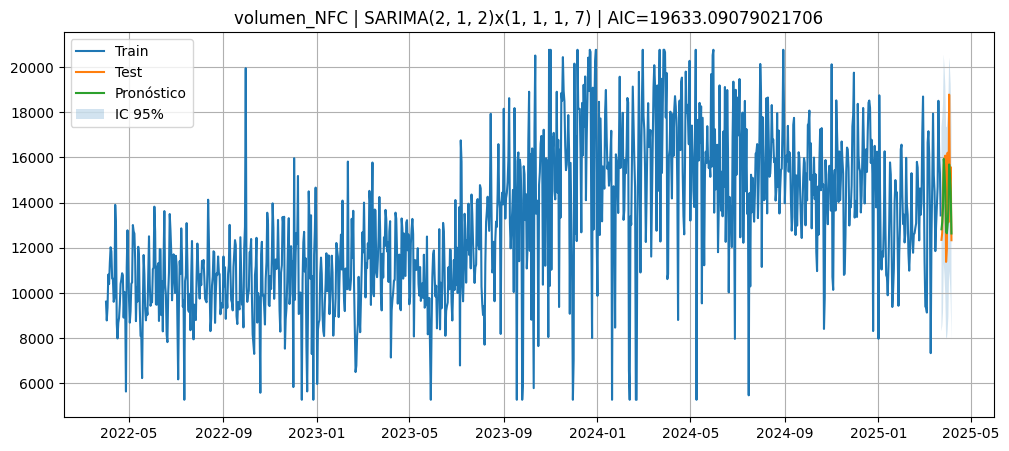

,order,seasonal_order,aic,bic
0,"(2, 1, 2)","(1, 1, 1, 7)",19633.090790,19667.918688
1,"(2, 1, 2)","(0, 1, 1, 7)",19637.960098,19667.812581
2,"(2, 1, 1)","(1, 1, 1, 7)",19649.535320,19679.393409
3,"(1, 1, 1)","(0, 1, 1, 7)",19655.118232,19675.023625
4,"(0, 1, 1)","(1, 1, 1, 7)",19665.982278,19685.887671


,Serie,Mejor_order,Mejor_seasonal,AIC,BIC,Params_signif(<0.05)/Total,"LR_stat,p,df (vs ARIMA(0,d,0))",LB_p(lag s),LB_p(lag 2s),MAE,RMSE,MAPE(%),sMAPE(%)
1,volumen_NFP,"(0, 1, 2)","(0, 1, 1, 7)",16229.154306,16249.055962,4/4,"(nan, nan, nan)",0.709272,0.290166,201.571888,293.609626,9.603480,9.630348
0,volumen_DSP,"(2, 0, 2)","(0, 1, 1, 7)",18651.763922,18681.622010,4/6,"(nan, nan, nan)",0.016618,0.000678,931.014031,1361.976512,13.014625,12.934823
2,volumen_NFC,"(2, 1, 2)","(1, 1, 1, 7)",19633.090790,19667.918688,7/7,"(nan, nan, nan)",0.644417,0.725484,1059.991657,1406.907744,7.021731,7.271481


In [12]:
resumen_todos = []
detalles_modelos = {}

for name, cfg in series_cfg.items():
    y = df[name].dropna().astype(float)
    print(f"\n=== {name} (d={cfg['d']}, s={cfg['s']}) ===")
    out = fit_best_sarima(y, d=cfg["d"], s=cfg["s"], h=H, series_name=name, criterion="aic")

    # Top-5 por AIC
    display(out["grid"].head(5)[["order","seasonal_order","aic","bic"]])

    # Resumen
    resumen_todos.append(out["summary"])
    detalles_modelos[name] = out

resumen_df = pd.DataFrame(resumen_todos).sort_values("AIC")
display(resumen_df)


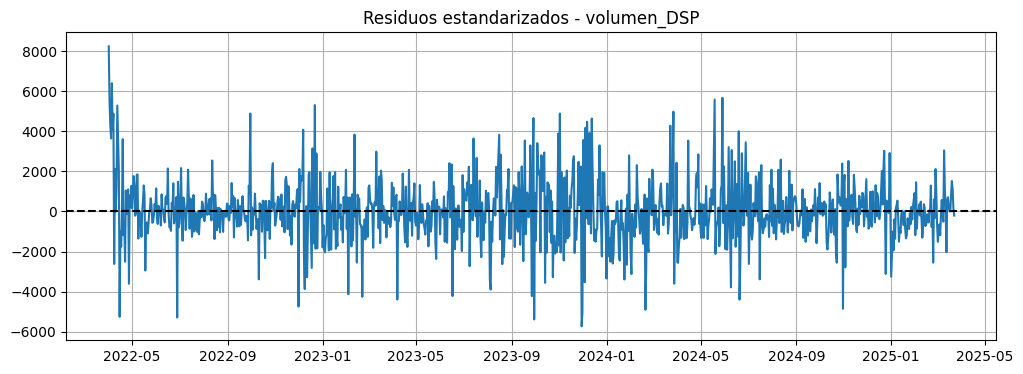

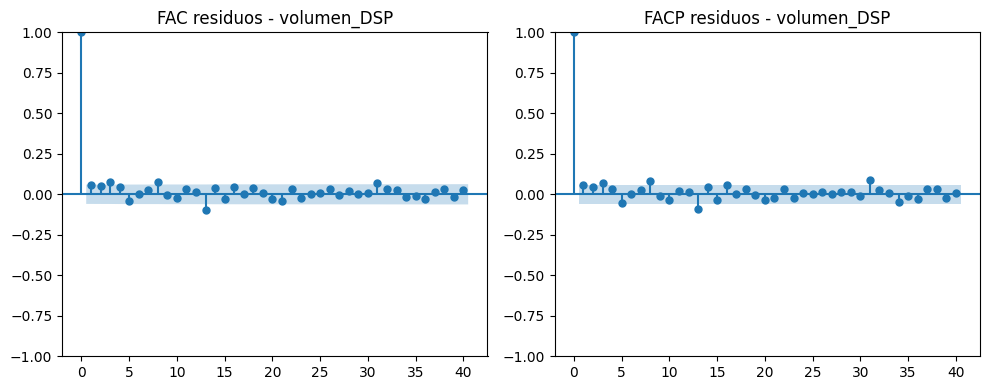


Test de Ljung–Box para volumen_DSP:
      lb_stat  lb_pvalue
7   17.123269   0.016618
14  37.240076   0.000678


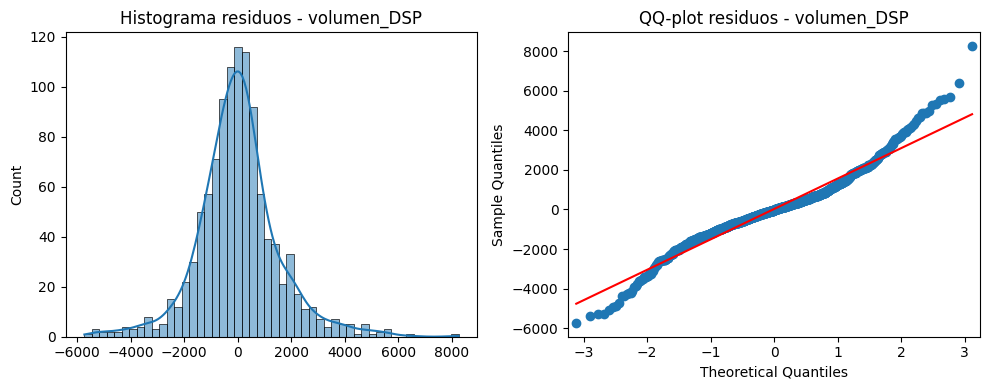


Test ARCH para volumen_DSP: F-stat=95.330, p-value=0.000


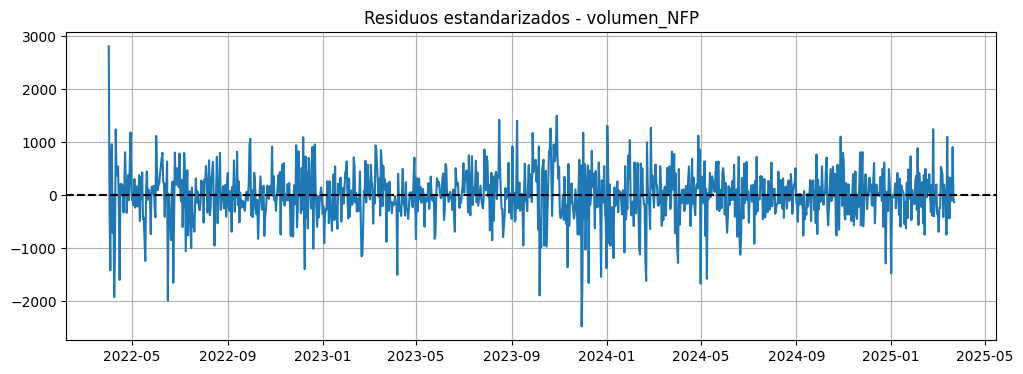

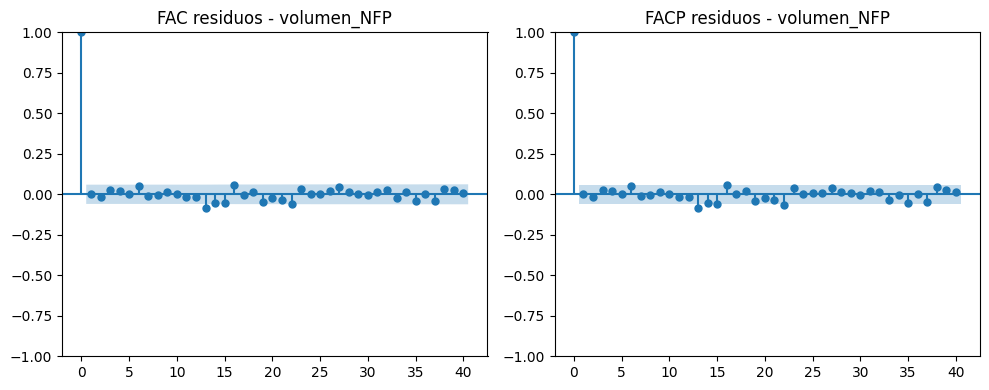


Test de Ljung–Box para volumen_NFP:
      lb_stat  lb_pvalue
7    4.594815   0.709272
14  16.389580   0.290166


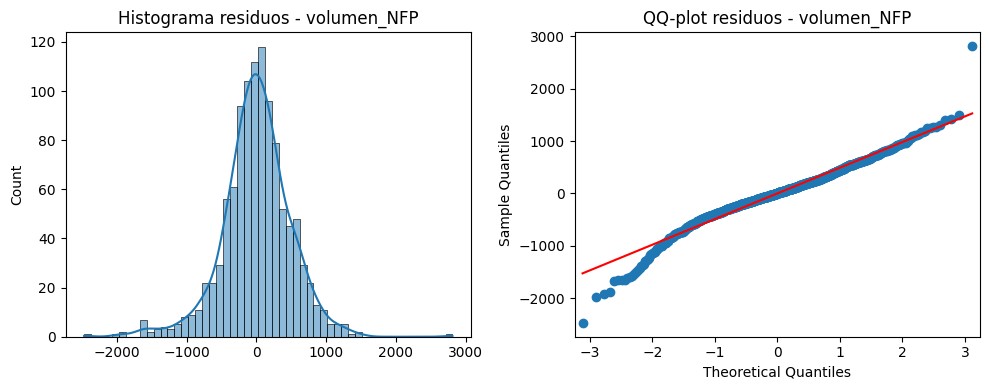


Test ARCH para volumen_NFP: F-stat=73.025, p-value=0.000


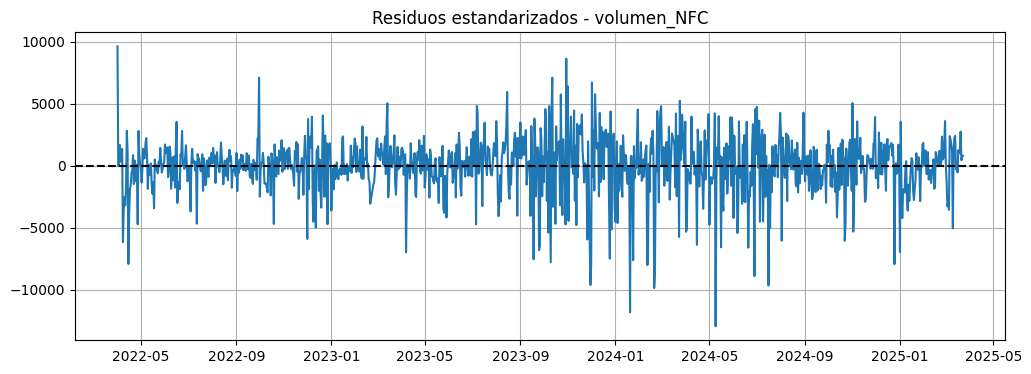

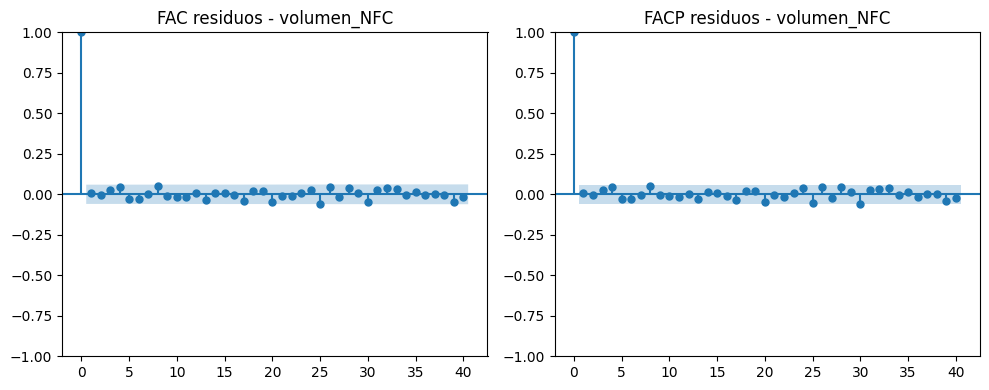


Test de Ljung–Box para volumen_NFC:
      lb_stat  lb_pvalue
7    5.127421   0.644417
14  10.490911   0.725484


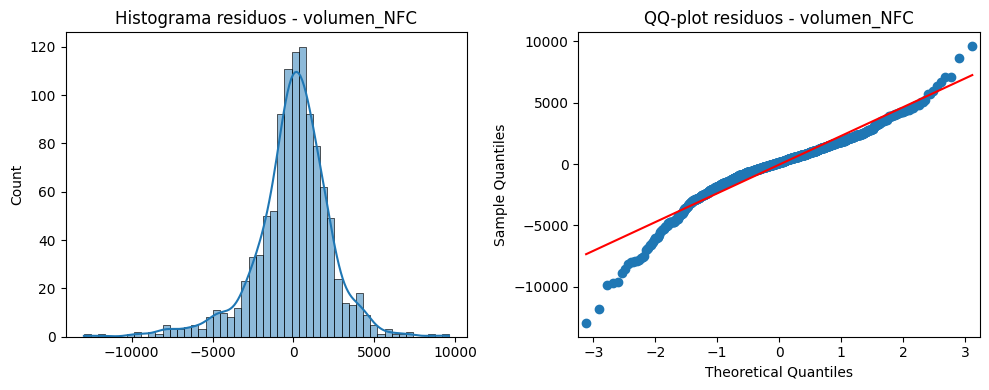


Test ARCH para volumen_NFC: F-stat=76.618, p-value=0.000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def diagnostico_residuos(fit, serie_name, s=7):
    resid = fit.resid.dropna()

    # 1. Serie de residuos
    plt.figure(figsize=(12,4))
    plt.plot(resid)
    plt.axhline(0, color="black", linestyle="--")
    plt.title(f"Residuos estandarizados - {serie_name}")
    plt.grid(True)
    plt.show()

    # 2. ACF y PACF de residuos
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    plot_acf(resid, lags=40, ax=axes[0])
    axes[0].set_title(f"FAC residuos - {serie_name}")
    plot_pacf(resid, lags=40, ax=axes[1], method="ywm")
    axes[1].set_title(f"FACP residuos - {serie_name}")
    plt.tight_layout()
    plt.show()

    # 3. Ljung–Box test
    lb = acorr_ljungbox(resid, lags=[s, 2*s], return_df=True)
    print(f"\nTest de Ljung–Box para {serie_name}:")
    print(lb)

    # 4. Histograma y QQ-plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(resid, kde=True, ax=axes[0])
    axes[0].set_title(f"Histograma residuos - {serie_name}")
    sm.qqplot(resid, line='s', ax=axes[1])
    axes[1].set_title(f"QQ-plot residuos - {serie_name}")
    plt.tight_layout()
    plt.show()

    # 5. Test de heterocedasticidad ARCH (opcional)
    arch_test = het_arch(resid)
    print(f"\nTest ARCH para {serie_name}: F-stat={arch_test[0]:.3f}, p-value={arch_test[1]:.3f}")

# Ejecutar para cada serie
import statsmodels.api as sm

for serie in ["volumen_DSP", "volumen_NFP", "volumen_NFC"]:
    fit = detalles_modelos[serie]["fit"]
    diagnostico_residuos(fit, serie, s=7)


In [14]:

def plot_forecast_fixed(fit, serie_name, H=7, hist_window=90):
    """
    Plotea bien alineado: últimos `hist_window` días del histórico + H pasos de forecast.
    Usa las etiquetas de fila (fechas) con las que se entrenó el SARIMAX.
    """
    # 1) Histórico con índice fecha del ajuste
    try:
        # statsmodels >= 0.12: row_labels conserva el índice original
        idx_hist = pd.DatetimeIndex(fit.model.data.row_labels)
    except Exception:
        # fallback: probar con data.orig_rowlabels (versiones viejas)
        idx_hist = pd.DatetimeIndex(getattr(fit.model.data, "orig_rowlabels", None))

    y_hist = pd.Series(fit.data.endog, index=idx_hist).astype(float)

    # 2) Forecast e intervalos
    pred = fit.get_forecast(steps=H)
    f_mean = pred.predicted_mean
    f_int  = pred.conf_int()

    # 3) Ventana del histórico a mostrar
    y_plot = y_hist.iloc[-hist_window:] if len(y_hist) > hist_window else y_hist

    # 4) Plot
    plt.figure(figsize=(12,5))
    plt.plot(y_plot.index, y_plot.values, label="Serie observada")
    plt.plot(f_mean.index, f_mean.values, label="Pronóstico", color="green")
    try:
        plt.fill_between(f_int.index, f_int.iloc[:,0], f_int.iloc[:,1],
                         alpha=0.2, color="orange", label="IC 95%")
    except Exception:
        pass
    plt.title(f"Pronóstico {serie_name} - SARIMA seleccionado")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    return f_mean, f_int



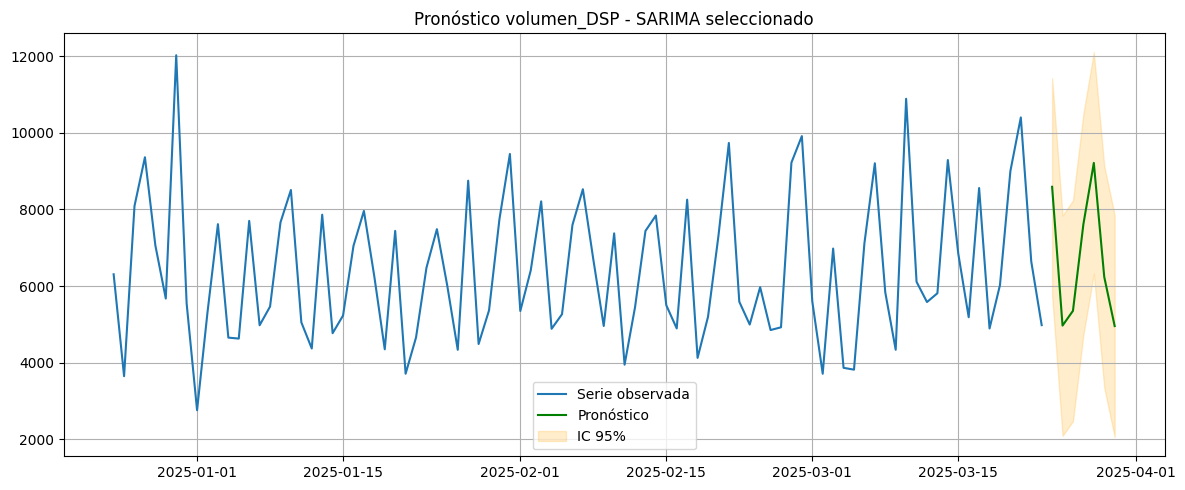

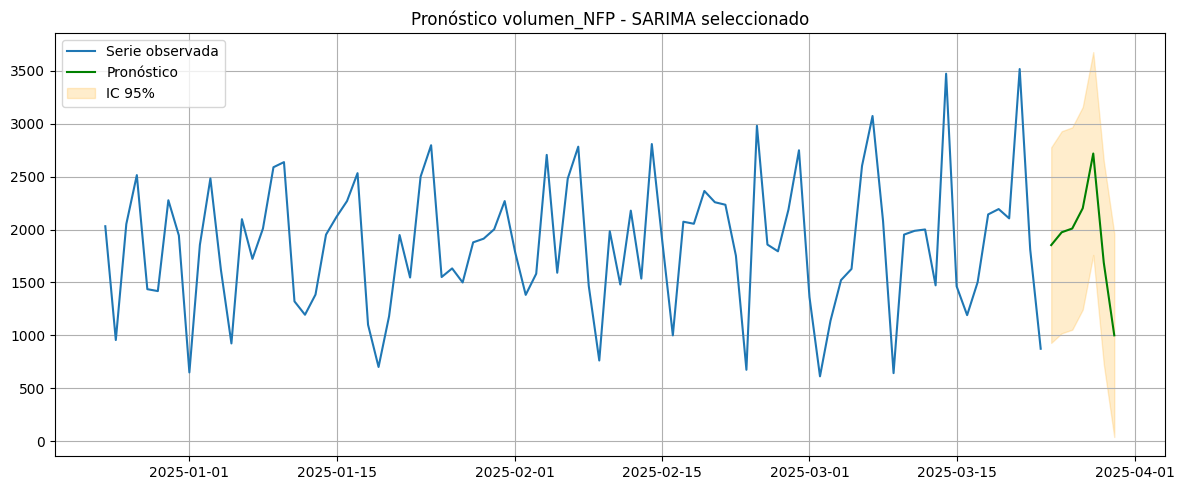

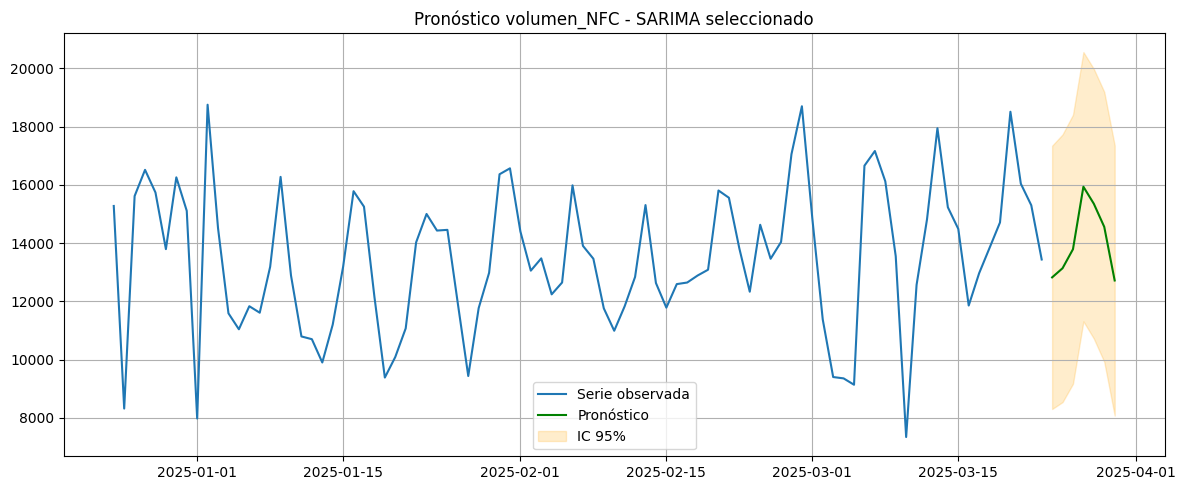

In [15]:
# Ejemplo: pronosticar 7 días para cada serie con el modelo ya ajustado
H = 7
forecast_results = {}
for serie in ["volumen_DSP", "volumen_NFP", "volumen_NFC"]:
    fit = detalles_modelos[serie]["fit"]
    f_mean, f_int = plot_forecast_fixed(fit, serie, H=H, hist_window=90)
    forecast_results[serie] = {"mean": f_mean, "interval": f_int}

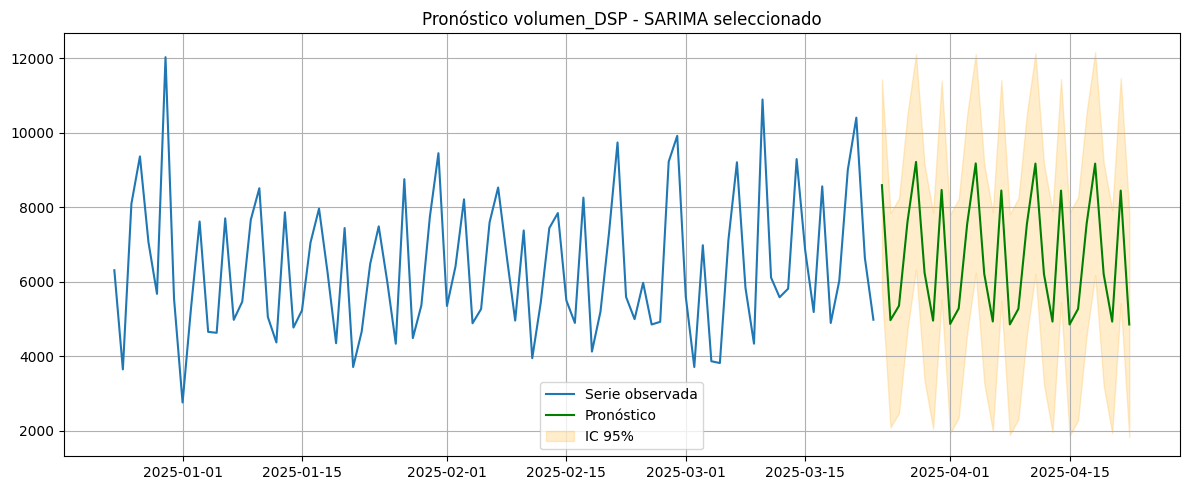

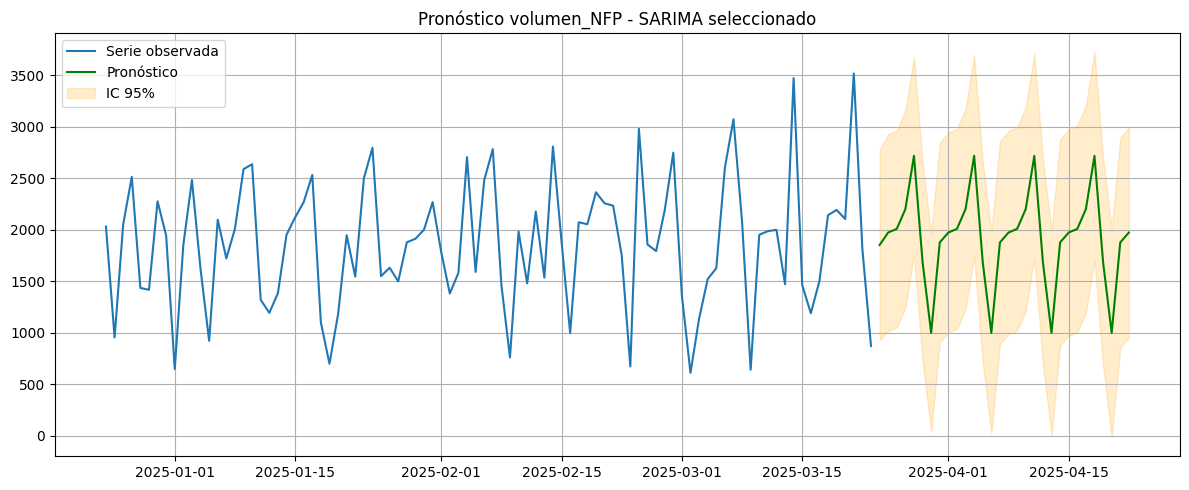

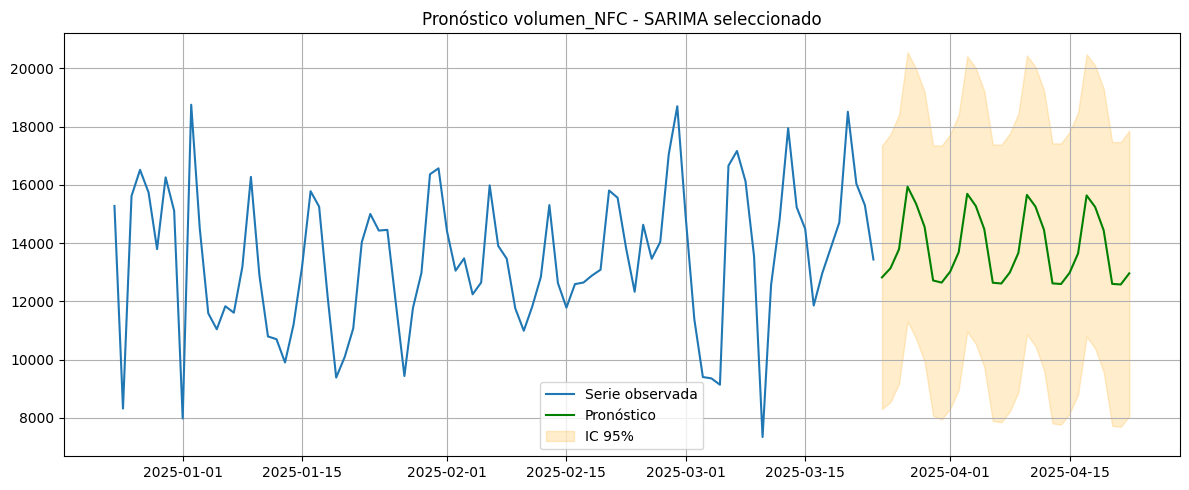

In [16]:
# Ejemplo: pronosticar 7 días para cada serie con el modelo ya ajustado
H = 30
forecast_results = {}
for serie in ["volumen_DSP", "volumen_NFP", "volumen_NFC"]:
    fit = detalles_modelos[serie]["fit"]
    f_mean, f_int = plot_forecast_fixed(fit, serie, H=H, hist_window=90)
    forecast_results[serie] = {"mean": f_mean, "interval": f_int}